In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)
import seaborn as sns

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PowerTransformer

import lightgbm as lgbm


In [2]:
sys.path.append('../../')
import src.utils as utils

In [3]:
EXP_NUM = 1

In [4]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [5]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
seasons = pd.read_csv(MAIN_DATA_DIR / 'seasons.csv')


In [6]:
seasons = seasons.fillna('1970-01-01')
for c_ in seasons.columns[1:]:
    seasons[c_] = pd.to_datetime(seasons[c_].str.replace('-', '').astype(int), format="%Y%m%d")

In [7]:
seasons

,seasonId,seasonStartDate,seasonEndDate,preSeasonStartDate,preSeasonEndDate,regularSeasonStartDate,regularSeasonEndDate,lastDate1stHalf,allStarDate,firstDate2ndHalf,postSeasonStartDate,postSeasonEndDate
0,2017,2017-04-02,2017-11-01,2017-02-22,2017-04-01,2017-04-02,2017-10-01,2017-07-09,2017-07-11,2017-07-14,2017-10-03,2017-11-01
1,2018,2018-03-29,2018-10-28,2018-02-21,2018-03-27,2018-03-29,2018-10-01,2018-07-15,2018-07-17,2018-07-19,2018-10-02,2018-10-28
2,2019,2019-03-20,2019-10-30,2019-02-21,2019-03-26,2019-03-20,2019-09-29,2019-07-07,2019-07-09,2019-07-11,2019-10-01,2019-10-30
3,2020,2020-07-23,2020-10-28,2020-02-21,2020-07-22,2020-07-23,2020-09-27,2020-08-25,1970-01-01,2020-08-26,2020-09-29,2020-10-28
4,2021,2021-02-28,2021-10-31,2021-02-28,2021-03-30,2021-04-01,2021-10-03,2021-07-11,2021-07-13,2021-07-15,2021-10-04,2021-10-31


In [8]:
player_target_stats = pd.read_csv(MAIN_DATA_DIR / "player_target_stats.csv")

In [37]:
oof = pd.read_csv('../50/output/oof50.csv')

In [38]:
oof

,Unnamed: 0,playerId,target1,target2,target3,target4,date
0,448,112526,0.020682,1.153607,0.061095,9.016889,20200801
1,449,112526,0.020682,1.153607,0.061095,9.036533,20200802
2,450,112526,0.020682,1.153607,0.061095,9.094433,20200803
3,451,112526,0.020682,1.153607,0.061095,9.094433,20200804
4,452,112526,0.020682,1.153607,0.061095,9.000219,20200805
...,...,...,...,...,...,...,...
309145,1234534,685503,0.016018,2.138402,0.040052,0.692298,20210426
309146,1234535,685503,0.012177,2.138402,0.040052,0.675040,20210427
309147,1234536,685503,0.011253,2.138402,0.040052,0.693931,20210428
309148,1234537,685503,0.013948,2.138402,0.040177,0.681859,20210429


In [39]:
targets

,engagementMetricsDate,playerId,target1,target2,target3,target4,index,date
0,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294,0,20180101
1,2018-01-02,547989,0.042993,5.593385,0.045033,2.794118,0,20180101
2,2018-01-02,519317,0.974327,56.177043,13.693746,64.166667,0,20180101
3,2018-01-02,607625,0.006700,2.675097,0.005168,1.862745,0,20180101
4,2018-01-02,592547,0.001117,0.632296,0.002953,0.931373,0,20180101
...,...,...,...,...,...,...,...,...
2506171,2021-05-01,451661,0.000000,0.013314,0.000000,0.625925,1215,20210430
2506172,2021-05-01,519301,0.000131,0.003329,0.000000,0.216229,1215,20210430
2506173,2021-05-01,527055,0.000000,0.019971,0.000000,0.273131,1215,20210430
2506174,2021-05-01,543484,0.000131,0.056586,0.000000,1.024240,1215,20210430


In [40]:
oof = pd.merge(oof, targets, how='left', on=['playerId', 'date'])
oof

,Unnamed: 0,playerId,target1_x,target2_x,target3_x,target4_x,date,engagementMetricsDate,target1_y,target2_y,target3_y,target4_y,index
0,448,112526,0.020682,1.153607,0.061095,9.016889,20200801,2020-08-02,0.002807,0.326694,0.025182,2.937599,943
1,449,112526,0.020682,1.153607,0.061095,9.036533,20200802,2020-08-03,0.002362,0.292740,0.021491,5.305229,944
2,450,112526,0.020682,1.153607,0.061095,9.094433,20200803,2020-08-04,0.007980,0.477913,0.020931,17.719091,945
3,451,112526,0.020682,1.153607,0.061095,9.094433,20200804,2020-08-05,0.012904,0.646713,0.015896,13.721325,946
4,452,112526,0.020682,1.153607,0.061095,9.000219,20200805,2020-08-06,0.009466,0.477344,0.019463,14.080079,947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309145,1234534,685503,0.016018,2.138402,0.040052,0.692298,20210426,2021-04-27,0.044617,1.224728,0.009437,0.737463,1211
309146,1234535,685503,0.012177,2.138402,0.040052,0.675040,20210427,2021-04-28,0.019123,1.178880,0.013161,0.790301,1212
309147,1234536,685503,0.011253,2.138402,0.040052,0.693931,20210428,2021-04-29,0.015799,4.323489,0.002350,0.970273,1213
309148,1234537,685503,0.013948,2.138402,0.040177,0.681859,20210429,2021-04-30,0.018770,31.946021,0.305491,5.938273,1214


In [41]:
oof = pd.merge(oof, scores, how='left', on=['playerId', 'date']) 


In [50]:
oof['gameday'] = ~oof['battingOrder'].isna()*1

In [51]:
len(oof[oof['gameday'] ==1]), len(oof[oof['gameday'] ==0])

(35129, 274021)

In [52]:
mae = mean_absolute_error(oof.iloc[:, 2:6], oof.iloc[:, 8:12])
print("mae:", mae)

mae: 0.9994430230593083


In [60]:
tr_idxs = []
val_idxs = []
tr_idx = (oof['date'].astype(int) < 20191001)
val_idx = (oof['date'].astype(int) >= 20191001) & (oof['date'].astype(int) < 20191030)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (oof['date'].astype(int) < 20200801)
val_idx = (oof['date'].astype(int) >= 20200801) & (oof['date'].astype(int) < 20200901)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (oof['date'].astype(int) < 20200901)
val_idx = (oof['date'].astype(int) >= 20200901) & (oof['date'].astype(int) < 20201001)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (oof['date'].astype(int) < 20201001)
val_idx = (oof['date'].astype(int) >= 20201001) & (oof['date'].astype(int) < 20201030)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)


tr_idx = (oof['date'].astype(int) < 20210401)
val_idx = ~tr_idx
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

In [62]:
# mae = mean_absolute_error(oof[val_idxs[0]].iloc[:, 2:6], oof[val_idxs[0]].iloc[:, 8:12])
# print("fold1 mae:", mae)
mae = mean_absolute_error(oof[val_idxs[1]].iloc[:, 2:6], oof[val_idxs[1]].iloc[:, 8:12])
print("fold2 mae:", mae)
mae = mean_absolute_error(oof[val_idxs[2]].iloc[:, 2:6], oof[val_idxs[2]].iloc[:, 8:12])
print("fold3 mae:", mae)
mae = mean_absolute_error(oof[val_idxs[3]].iloc[:, 2:6], oof[val_idxs[3]].iloc[:, 8:12])
print("fold4 mae:", mae)
mae = mean_absolute_error(oof[val_idxs[4]].iloc[:, 2:6], oof[val_idxs[4]].iloc[:, 8:12])
print("fold5 mae:", mae)

fold2 mae: 0.9591598600259377
fold3 mae: 0.9387988551326177
fold4 mae: 0.42853832973226225
fold5 mae: 0.9204744613696203


In [53]:
mae = mean_absolute_error(oof[oof['gameday']==1].iloc[:, 2:6], oof[oof['gameday']==1].iloc[:, 8:12])
print("gameday_mae:", mae)
mae = mean_absolute_error(oof[oof['gameday']==0].iloc[:, 2:6], oof[oof['gameday']==0].iloc[:, 8:12])
print("notgameday_mae:", mae)

gameday_mae: 2.5540305460908344
notgameday_mae: 0.8001476949765172


In [49]:
mae = mean_absolute_error(oof.iloc[:, 2], oof.iloc[:, 8])
print("target1_mae:", mae)
mae = mean_absolute_error(oof.iloc[:, 3], oof.iloc[:, 9])
print("target2_mae:", mae)
mae = mean_absolute_error(oof.iloc[:, 4], oof.iloc[:, 10])
print("target3_mae:", mae)
mae = mean_absolute_error(oof.iloc[:, 5], oof.iloc[:, 11])
print("target4_mae:", mae)

target1_mae: 0.5911040374002094
target2_mae: 1.6534269599852855
target3_mae: 0.6468423489602801
target4_mae: 1.106398745891458


In [22]:
from scipy import stats

0.5775100972283256

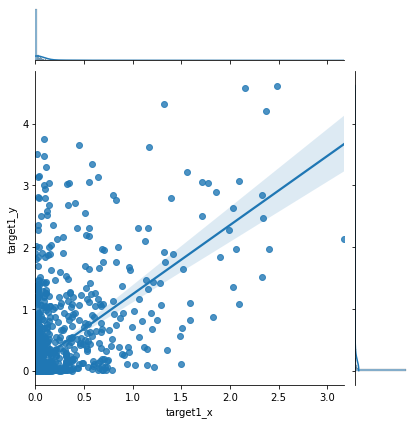

In [32]:
x_ = np.log(oof["target1_x"][::100]+1)
y_ = np.log(oof["target1_y"][::100]+1)
sns.jointplot(x=x_, y=y_, kind="reg")
np.corrcoef(x_, y_)[0, 1]

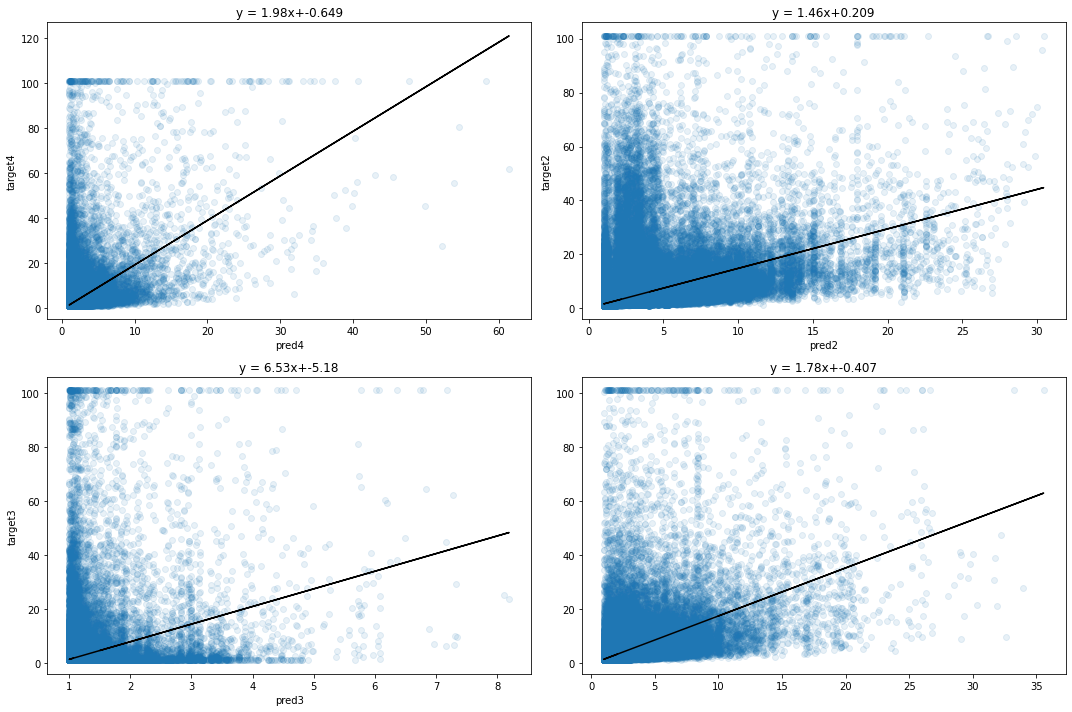

In [57]:
from sklearn import linear_model


fig = plt.figure(figsize=(15, 10))

pred_x = (oof["target1_x"]+1).values.reshape(-1,1)
target_x = (oof["target1_y"]+1).values.reshape(-1,1)
reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)
ax1 = fig.add_subplot(221)
ax1.plot(pred_x, reg1.predict(pred_x), color='black')
ax1.scatter(pred_x, target_x, alpha=0.1)
ax1.set_xlabel('pred1')
ax1.set_ylabel('target1')
ax1.set_title('y = {:.3g}x+{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))


pred_x = (oof["target2_x"]+1).values.reshape(-1,1)
target_x = (oof["target2_y"]+1).values.reshape(-1,1)
reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)
ax2 = fig.add_subplot(222)
ax2.plot(pred_x, reg1.predict(pred_x), color='black')
ax2.scatter(pred_x, target_x, alpha=0.1)
ax2.set_xlabel('pred2')
ax2.set_ylabel('target2')
ax2.set_title('y = {:.3g}x+{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))

pred_x = (oof["target3_x"]+1).values.reshape(-1,1)
target_x = (oof["target3_y"]+1).values.reshape(-1,1)
reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)
ax3 = fig.add_subplot(223)
ax3.plot(pred_x, reg1.predict(pred_x), color='black')
ax3.scatter(pred_x, target_x, alpha=0.1)
ax3.set_xlabel('pred3')
ax3.set_ylabel('target3')
ax3.set_title('y = {:.3g}x+{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))

pred_x = (oof["target4_x"]+1).values.reshape(-1,1)
target_x = (oof["target4_y"]+1).values.reshape(-1,1)
reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)
ax4 = fig.add_subplot(224)
ax4.plot(pred_x, reg1.predict(pred_x), color='black')
ax4.scatter(pred_x, target_x, alpha=0.1)
ax1.set_xlabel('pred4')
ax1.set_ylabel('target4')
ax4.set_title('y = {:.3g}x+{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))

plt.tight_layout()